In [20]:
from tqdm.notebook import tqdm
import pandas as pd
import openai
import json
import os

openai.api_key = os.environ["OPENAI_API_KEY"]

In [21]:
wiki_sci_df = pd.read_parquet("../data/wikipedia_pages2_w_embd/wiki_sci_embd_clusters.parquet").reset_index(drop=True)

# calculate word count from 'text' column
wiki_sci_df['word_count'] = wiki_sci_df['text'].apply(lambda x: len(str(x).split(" ")))
wiki_sci_df['section_title'] = wiki_sci_df['title']
wiki_sci_df['page'] = wiki_sci_df['title']


wiki_sci_df.head()

,text,url,title,embd_text,embd_title,text_length,cluster_text,cluster_title,word_count,section_title,page
0,The Ulakhan Fault is a left-lateral moving tra...,https://en.wikipedia.org/wiki/Ulakhan%20Fault,Ulakhan Fault,"[-0.010125404, 0.045413326, -0.0055074026, 0.0...","[-0.027042245, 0.02827163, -0.007891712, -0.01...",948,789,144,137,Ulakhan Fault,Ulakhan Fault
1,Tripodal ligands are tri- and tetradentate lig...,https://en.wikipedia.org/wiki/Tripodal%20ligand,Tripodal ligand,"[-0.008397752, -0.007900611, 0.028120818, 0.02...","[0.0025610395, -0.0058939615, 0.015708892, 0.0...",1313,1,510,182,Tripodal ligand,Tripodal ligand
2,WASP-14b is an extrasolar planet discovered in...,https://en.wikipedia.org/wiki/WASP-14b,WASP-14b,"[0.021130525, 0.019535448, 0.028013904, -0.006...","[0.02375302, 0.011801232, 0.02509789, 0.001614...",852,334,499,122,WASP-14b,WASP-14b
3,Long-acting reversible contraceptives (LARC) a...,https://en.wikipedia.org/wiki/Long-acting%20re...,Long-acting reversible contraception,"[-0.014279559, -0.005928753, -0.02585963, 0.01...","[0.0039009643, 0.0050253584, -0.0144014275, 0....",9431,15,326,1414,Long-acting reversible contraception,Long-acting reversible contraception
4,"AIDS (""acquired immune deficiency syndrome"") i...",https://en.wikipedia.org/wiki/HIV%20integration,HIV integration,"[-0.02654824, -0.008117266, -0.0044153593, 0.0...","[-0.0016449259, -0.004117463, -0.02023814, 0.0...",10557,7,895,1685,HIV integration,HIV integration


In [22]:
wc_per_page = wiki_sci_df.groupby("page")[["word_count"]].sum().sort_values("word_count", ascending=False)
wc_per_page["token_count"] = (wc_per_page["word_count"] / 0.75).astype(int)
wc_per_page[:20]

,word_count,token_count
page,,
"List of International Organization for Standardization standards, 1-4999",68671,91561
Stars and planetary systems in fiction,38589,51452
List of vacuum tubes,32967,43956
List of accidents and incidents involving airliners by location,24392,32522
Safety of electronic cigarettes,23041,30721
Weather of 2010,22405,29873
List of unnumbered minor planets: 2003 S (443–619),20829,27772
List of unnumbered minor planets: 2002 U–V,20381,27174
List of birds of Asia,19683,26244


In [23]:
# sum all token_count
wc_per_page['token_count'].sum() / 1e8

1.21440621

In [24]:
# remove rows where "List of" is in the page
wiki_sci_df = wiki_sci_df[~wiki_sci_df['page'].str.contains('List of')]

In [25]:
wc_per_page = wiki_sci_df.groupby("page")[["word_count"]].sum().sort_values("word_count", ascending=False)
wc_per_page["token_count"] = (wc_per_page["word_count"] / 0.75).astype(int)
wc_per_page[:20]

,word_count,token_count
page,,
Stars and planetary systems in fiction,38589,51452
Safety of electronic cigarettes,23041,30721
Weather of 2010,22405,29873
Glossary of medicine,19234,25645
Cathode-ray tube,18973,25297
Metalloid,18804,25072
Magic square,18784,25045
Hydrogen isotope biogeochemistry,18556,24741
Government incentives for plug-in electric vehicles,17823,23764


In [26]:
# sum all token_count
wc_per_page['token_count'].sum() / 1e8

1.18184593

# Expected cost: 	


GPT3.5 cost for 16k context is $0.004 / 1K tokens.

There is 1e8 tokens in the dataset, so the cost is 1e8 * 0.004 / 1e3 = $400 for the whole wiki sci dataset.

There is about 130 text examples per cluster, so the cost per cluster is $400 / 130 = $3.07

In [27]:
(wc_per_page['token_count']  > 16e3).sum() / len(wc_per_page)

0.0004102865813064144

In [28]:
# openai.Model.list()

In [29]:
import pydantic


pydantic.__version__

'2.1.1'

In [30]:
from typing import *
from pydantic import BaseModel
import json


class MultipleChoiceQuestion(BaseModel):
    question: str
    A: str
    B: str
    C: str
    D: str
    E: str
    answer: Literal["A", "B", "C", "D", "E"]

        
class MultipleChoiceQuestionList(BaseModel):
    questions: List[MultipleChoiceQuestion]

        
schema = MultipleChoiceQuestionList.model_json_schema()
# print(json.dumps(schema, indent=4))

In [31]:
from pathlib import Path


# out_file_name = "raw_questions"
# out_file_name = "raw_questions_2"
out_file_name = "raw_questions_wiki_sci_2"


out_dir = Path(f"../data/data_dumps/{out_file_name}")

# if the directory already exist, raise an error
out_dir.mkdir(exist_ok=True, parents=True)

In [32]:
wiki_sci_df

,text,url,title,embd_text,embd_title,text_length,cluster_text,cluster_title,word_count,section_title,page
0,The Ulakhan Fault is a left-lateral moving tra...,https://en.wikipedia.org/wiki/Ulakhan%20Fault,Ulakhan Fault,"[-0.010125404, 0.045413326, -0.0055074026, 0.0...","[-0.027042245, 0.02827163, -0.007891712, -0.01...",948,789,144,137,Ulakhan Fault,Ulakhan Fault
1,Tripodal ligands are tri- and tetradentate lig...,https://en.wikipedia.org/wiki/Tripodal%20ligand,Tripodal ligand,"[-0.008397752, -0.007900611, 0.028120818, 0.02...","[0.0025610395, -0.0058939615, 0.015708892, 0.0...",1313,1,510,182,Tripodal ligand,Tripodal ligand
2,WASP-14b is an extrasolar planet discovered in...,https://en.wikipedia.org/wiki/WASP-14b,WASP-14b,"[0.021130525, 0.019535448, 0.028013904, -0.006...","[0.02375302, 0.011801232, 0.02509789, 0.001614...",852,334,499,122,WASP-14b,WASP-14b
3,Long-acting reversible contraceptives (LARC) a...,https://en.wikipedia.org/wiki/Long-acting%20re...,Long-acting reversible contraception,"[-0.014279559, -0.005928753, -0.02585963, 0.01...","[0.0039009643, 0.0050253584, -0.0144014275, 0....",9431,15,326,1414,Long-acting reversible contraception,Long-acting reversible contraception
4,"AIDS (""acquired immune deficiency syndrome"") i...",https://en.wikipedia.org/wiki/HIV%20integration,HIV integration,"[-0.02654824, -0.008117266, -0.0044153593, 0.0...","[-0.0016449259, -0.004117463, -0.02023814, 0.0...",10557,7,895,1685,HIV integration,HIV integration
...,...,...,...,...,...,...,...,...,...,...,...
131044,"Abbe error, named after Ernst Abbe, also calle...",https://en.wikipedia.org/wiki/Abbe%20error,Abbe error,"[0.0014070617, -0.0007498502, 0.010993658, -0....","[-0.0031289584, -0.0031333594, -0.008495317, -...",964,116,752,150,Abbe error,Abbe error
131045,"Thymus hyperplasia refers to an enlargement (""...",https://en.wikipedia.org/wiki/Thymus%20hyperpl...,Thymus hyperplasia,"[-0.007014362, -0.033683073, 0.0069677155, 0.0...","[-0.025568478, -0.011568436, 0.005710415, -0.0...",578,922,567,84,Thymus hyperplasia,Thymus hyperplasia
131046,"Neramexane is a drug related to memantine, whi...",https://en.wikipedia.org/wiki/Neramexane,Neramexane,"[-0.0056811613, 0.006054821, -0.022076461, 0.0...","[-0.026682014, 0.02342553, 0.0042701247, 0.028...",682,453,237,93,Neramexane,Neramexane
131047,MiWi is a proprietary wireless protocol suppor...,https://en.wikipedia.org/wiki/MiWi,MiWi,"[-0.01738712, -0.0004084214, 0.0017437936, 0.0...","[-0.016711572, 0.006456733, -0.026016701, -0.0...",3990,428,37,548,MiWi,MiWi


In [33]:
import numpy as np
clusters = np.array(list(set(wiki_sci_df.cluster_text.values)))
clusters[:10], clusters.shape

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), (999,))

In [34]:
wiki_sci_df = wiki_sci_df[:5]

In [35]:
clusters = np.array(list(set(wiki_sci_df.cluster_text.values)))
clusters[:10], clusters.shape

(array([  1,   7, 334,  15, 789], dtype=int32), (5,))

In [36]:




num_questions_per_round = 1
num_questions_per_cluster = 1

In [37]:

    
def generate_questions(cluster):
    
    print(f"Generating data for cluster: {cluster}")
    wiki_sci_df_cluster = wiki_sci_df[wiki_sci_df.cluster_text == cluster].reset_index(drop=True)
    
    
    for cluster_question_idx  in range(num_questions_per_cluster):
        
        out_path = f"{out_dir}/cluster-{cluster}-round-{cluster_question_idx}.txt"
        
        
        # take a random page and text from wiki_sci_df_cluster
        random_row = wiki_sci_df_cluster.sample(1)
        page = random_row.page.values[0]
        text = random_row.text.values[0]
        section_title = random_row.section_title.values[0]
        
        try:
            # ==== prompt building ====
            model_name = "gpt-3.5-turbo-16k-0613"
            messages = [
                {
                    "role": "system", 
                    "content": (
                        f"You are a GOD-like AGI that is a top level expert in all of the fields in the world. "
                        + f"Your task is to design a multiple choice exam questions with 5 choices each for human experts in the field. "
                        + f"Of these 5 possible answers, one is correct and the other 4 are wrong. "
                        + f"Your exam questions will be derived from a wikipedia page: \"{page}\". "
                        + f"You'll receive a pair of section_title and text extracted from the wikipedia page. "
                        + f"Even though the answers are generated from the wikipedia page, your students are super smart, so don't go easy on them. "
                        + f"It is OK if the questions relates some concept from the given wikipedia page to another concept from another wikipedia page if you want to ask a question that is more difficult and that questions the student's understanding of both concepts. \n"
                        + f"Make sure that the exam questions (both the correct answer and the wrong answers) you design are relevant to the given section_title and text."
                        + f"The possible answers should be very similar to the exact answer. "
                        + f"Think step-by-step, and make sure that the answer is not too obvious. "
                        + f"Don't include possible answers that are like 'any of the above' or 'none of the above'. "
                        + f"Here are the section title and text: \n"
                        + f"Section title: {section_title}. Text: {text}"
                    )
                },
                {
                    "role": "user",
                    "content": f"Generate {num_questions_per_round} multiple choice questions, each with 5 possible answers on the given topic. You will generate it in the following way, step-by-step:\n"
                    + f"Step 1: you will generate a question and a correct answer based on the provided text. The answer is 1 or 2 sentences long, no longer than that. Write that down as the token outputs. Question should start like this: \n"
                    
                    + f"option: What is the significance of ... \n"
                    + f"option: Which of the following statements ... \n"
                    + f"option: What is ... \n"
                    + f"option: What is the difference between ... \n"
                    + f"option: What is the reason for ... \n"
                    + f"option: What is the role of ... \n"
                    + f"option: What is the definition of ... \n"
                    + f"option: What is the purpose of ... \n"
                    + f"option: What is the reason behind ... \n"
                    + f"option: What is the term used ... \n"
                    + f"option: What is the origin of ... \n"
                    + f"option: What are the two main ... \n"
                    + f"option: What is the reason that ... \n"
                    + f"option: What is the main focus ... \n"
                    + f"option: What is the function of ... \n"
                    + f"option: What is the interpretation of ... \n"
                    + f"option: What is the formalism that ... \n"
                    + f"option: What is the main advantage ... \n"
                    
                    + f"Step 2: you will generate 4 similar but wrong answers based on the correct answer that you provided in the step 1. Start the sentence the same as the answer, but only change wording in few places to make sure the answer is actually wrong. Make sure that the wrong answer is not too obviously wrong, that is as close to the correct answer as possible, not similar to other wrong answers. The number of sentences should be the same as the correct answer.\n"
                    
                    + f"Examples of question-correct answer pairs:\n"
                    + "['What is the Kutta condition?','The Kutta condition is a physical requirement that the fluid moving along the lower and upper surfaces of an airfoil meet smoothly, with no fluid moving around the trailing edge of the airfoil.'],"
                    + f"['What is the purpose of obtaining surgical resection specimens?','To remove an entire diseased area or organ for definitive surgical treatment of a disease, with pathological analysis of the specimen used to confirm the diagnosis.']"
                    + f"['Who published the first theory that was able to encompass previously separate field theories to provide a unifying theory of electromagnetism?, 'Maxwell']"
                    + f"['What is the significance of Baryon Acoustic Oscillations (BAOs) in the study of the universe?','BAOs establish a preferred length scale for baryons, which can be used to detect a subtle preference for pairs of galaxies to be separated by 147 Mpc, compared to those separated by 130-160 Mpc.']"
                }
            ]

            
            
            # ==== running model ====
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=messages,
                functions=[
                    {
                        "name": "create_multiple_choice_question",
                        "description": "create a multiple choice question consisting of a question, and 5 choices: A, B, C, D, and E",
                        "parameters": schema,
                    }
                ],
                function_call={"name": "create_multiple_choice_question"},
            )

            # ==== parsing answers ====
            assistant_msg = response["choices"][0]["message"]
            response_options = assistant_msg.to_dict()["function_call"]["arguments"]
            
            
            # write response_options to out_path
            out_path_write = Path(out_path)
            out_path_write.write_text(response_options)
                
        except (
            openai.error.Timeout,
            openai.error.APIError,
            openai.error.APIConnectionError,
            openai.error.InvalidRequestError,
            openai.error.AuthenticationError,
            openai.error.PermissionError,
            openai.error.RateLimitError,
        ) as e:
            print(f"can't do {page}: {repr(e)}, skipping for now")
            continue
        
        
        

In [38]:

from joblib import Parallel, delayed
from tqdm import tqdm

n_jobs = 64

results = Parallel(n_jobs=n_jobs)(delayed(generate_questions)(cluster) for cluster in tqdm(clusters))


100%|██████████| 5/5 [00:00<00:00, 2515.78it/s]


Generating data for cluster: 15
Generating data for cluster: 1
Generating data for cluster: 789
Generating data for cluster: 334
Generating data for cluster: 7


In [ ]:
formatted_answers = []


answer_files = sorted(list(out_dir.glob("*.txt")))

for p in answer_files:
    try:
        parsed_file = json.loads(p.read_text())
        formatted_answers.append(parsed_file)
    except json.JSONDecodeError as e:
        print(f"cant decode: {p}, {e}")

print(f"parsed {len(formatted_answers)} / {len(answer_files)} files")

In [4]:
import pandas as pd
import json
from pathlib import Path

# Get a sorted list of all ".txt" files in the directory
answer_files = sorted(list(out_dir.glob("*.txt")))

failed_reads = 0
data_list = []

# Loop through each file
for p in answer_files:
    try:
        # Extract cluster number and round from the filename
        cluster_num = int(p.stem.split('-')[1])
        round_num = int(p.stem.split('-')[3])

        # Load file content with json.loads
        parsed_file = json.loads(p.read_text())

        for q in parsed_file["questions"]:
            data_list.append({
                "id": None,  # You'll need to decide how you want to generate the IDs
                "prompt": q["question"],
                "A": q["A"],
                "B": q["B"],
                "C": q["C"],
                "D": q["D"],
                "E": q["E"],
                "answer": q["answer"],
                "cluster number": cluster_num,
                "round": round_num
            })

    except Exception as e:
        # print(f"Failed reading file: {p.name}. Error: {e}")
        failed_reads += 1

print(f"Failed reads: {failed_reads}")

# Convert data_list into a dataframe
df = pd.DataFrame(data_list)

# Assign unique IDs to each row
df["id"] = range(1, len(df) + 1)



Failed reads: 178


In [13]:
# convert prompt	A	B	C	D	E	answer	 columns to string
df["prompt"] = df["prompt"].astype(str)
df["A"] = df["A"].astype(str)
df["B"] = df["B"].astype(str)
df["C"] = df["C"].astype(str)
df["D"] = df["D"].astype(str)
df["E"] = df["E"].astype(str)
df["answer"] = df["answer"].astype(str)

In [14]:
# "Which rows have 'What are the vascular bundles found in' in column 'prompt'?
df[df["prompt"].str.contains("What are the vascular bundles found in")]


,id,prompt,A,B,C,D,E,answer,cluster number,round
1128,1129,What are the vascular bundles found in the pet...,Single,Double,Multiple,Triple,None,A,294,1


In [6]:
# is there any none in the df?
df.isna().sum()

id                0
prompt            0
A                 0
B                 0
C                 0
D                 0
E                 0
answer            0
cluster number    0
round             0
dtype: int64

In [15]:
df

,id,prompt,A,B,C,D,E,answer,cluster number,round
0,1,What is the significance of HD 7924 b?,It is the first planet discovered in the const...,It is a super-Earth exoplanet with a minimum m...,It takes only about 129.5 hours to orbit the star,It is located approximately 55 light years away,It is a gaseous planet with unknown mass,B,0,0
1,2,What is the significance of HD 69830 b?,It is a gas giant exoplanet.,It takes 82/3 days to complete an orbit.,It is 10 times more massive than Earth.,Models predict that tidal heating would produc...,It orbits very close to its parent star.,B,0,1
2,3,What is the difference between HD 69830 b and ...,HD 69830 b takes 82/3 days to complete an orbi...,HD 69830 b is 10 times more massive than Earth...,HD 69830 b orbits very close to its parent sta...,"HD 69830 b is a rocky planet, while a gas gian...",HD 69830 b models predict that tidal heating w...,D,0,1
3,4,What is the reason for HD 69830 b not being a ...,It takes 82/3 days to complete an orbit.,It is 10 times more massive than Earth.,Models predict that tidal heating would produc...,It is a rocky planet.,It orbits very close to its parent star.,D,0,1
4,5,What is the role of tidal heating in HD 69830 b?,Tidal heating causes the high heat flux at the...,Tidal heating contributes to the 82/3 day orbi...,Tidal heating determines the rocky composition...,Tidal heating is responsible for the 10 times ...,Tidal heating allows HD 69830 b to orbit very ...,A,0,1
...,...,...,...,...,...,...,...,...,...,...
5222,5223,What is the significance of BL Herculis variab...,They have a longer period compared to other Ty...,They have a bump on the ascending side of thei...,They are population II stars found in the gala...,They have the same luminosity as RR Lyrae vari...,They are spectral class F at their brightest,C,999,0
5223,5224,What is the significance of X Crucis?,X Crucis is a type of pulsating variable star.,X Crucis is a population I star.,X Crucis is a classical Cepheid variable.,X Crucis is a G-type supergiant.,X Crucis is a Durchmusterung object.,A,999,1
5224,5225,What is the visual magnitude range of RW Cephei?,6.0 to 7.3,8.6 to 10.7,6.0 to 8.6,7.3 to 10.7,10.7 to 12.0,A,999,2
5225,5226,What is a variable star?,A star whose brightness remains constant over ...,A star whose brightness fluctuates as seen fro...,A star that emits different colors of light.,A star that exists in multiple places at once.,A star that only appears during certain seasons.,B,999,3


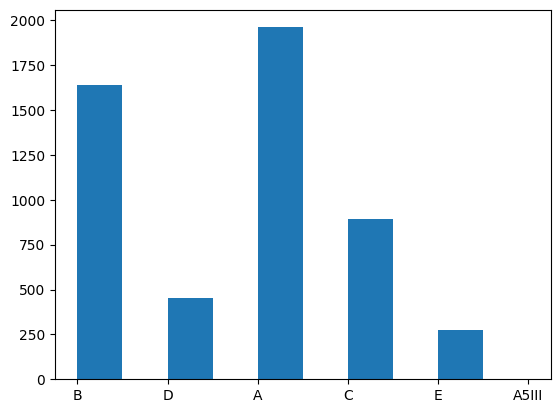

In [16]:
import matplotlib.pyplot as plt
plt.hist(df['answer']);

In [17]:
out_path = f"../data/data_dumps/more_questions/more_questions_{out_file_name}.csv"
print(out_path)
df.to_csv(out_path)

../data/data_dumps/more_questions/more_questions_raw_questions_wiki_sci_1.csv
